In [14]:
"""
Análisis Descriptivo de Preguntas Académicas: Categorías y Temas
================================================================

Este notebook se enfoca en el análisis exploratorio y descriptivo de:
1. Distribución por categorías (Derecho, Sociología, Técnico)
2. Distribución por temas (45 temas diferentes)
3. Visualizaciones interactivas y grafos de nodos
4. Análisis de similitud por embeddings

Objetivos:
- Entender la estructura y balance del dataset
- Visualizar relaciones entre categorías y temas
- Crear grafos de nodos diferenciados por colores
- Preparar insights para el entrenamiento de modelos
"""

import ast
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
from sklearn.cluster import KMeans
import warnings
from collections import Counter
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

warnings.filterwarnings('ignore')

# Configuración de estilo
plt.style.use('default')
sns.set_palette("husl")


def convert_string_to_array(vector_string):
    """Convierte string de vector a numpy array"""
    try:
        if vector_string is None or vector_string == '' or pd.isna(vector_string):
            return np.array([0])

        vector_string = str(vector_string).strip('[]')
        if not vector_string.strip():
            return np.array([0])

        vector_list = [float(x.strip()) for x in vector_string.split(',') if x.strip()]
        if not vector_list:
            return np.array([0])

        return np.array(vector_list)
    except Exception as e:
        try:
            return np.array(ast.literal_eval(vector_string))
        except:
            print(f"Warning: Could not parse vector '{vector_string}', using [0]")
            return np.array([0])


def pad_vector(vector, target_length):
    """Rellena vector con ceros hasta longitud objetivo"""
    if len(vector) < target_length:
        return np.pad(vector, (0, target_length - len(vector)), mode='constant')
    return vector



# 1. Carga y Preparación de Datos


In [15]:
import os
from utils.repository.repository import Repository

repo = Repository()

# Cargar datos
if not os.path.exists('data/augmented_questions_vector_category_chapter.csv'):
    print("Obteniendo preguntas del repositorio...")
    questions = repo.fetch_questions(limit=-1, min_number=1, max_number=45, is_vector=True)

    os.makedirs('data', exist_ok=True)
    df = pd.DataFrame([question.get_vector_category() for question in questions])
    df.to_csv('data/augmented_questions_vector_category_chapter.csv', index=False)
else:
    print("Cargando datos desde CSV...")
    df = pd.read_csv('data/augmented_questions_vector_category_chapter.csv').dropna()

print(f"Dataset cargado: {len(df)} preguntas")
print(f"Columnas: {list(df.columns)}")

# Mostrar muestra de datos
print("\nPrimeras 5 filas:")
print(df.head())


Repository initialized with Supabase client.
Cargando datos desde CSV...
Dataset cargado: 20072 preguntas
Columnas: ['text', 'vector', 'category', 'chapter']

Primeras 5 filas:
                                                text  \
0  En caso de fallecimiento del titular de los da...   
1  Artículo 90 Artículo 90. Derecho a la intimida...   
2  Disposición final cuarta Disposición final cua...   
3  Las sanciones impuestas en aplicación del Regl...   
4  ¿Qué principio debe respetarse especialmente a...   

                                              vector  category  chapter  
0  [-0.048611052,-0.00031063796,-0.0016865367,0.0...         1       26  
1  [-0.017364502,0.0074691772,0.0049858093,-0.019...         1       26  
2  [-0.014045715,-0.004814148,-9.346008e-05,0.024...         1       26  
3  [-0.039903883,-0.021522962,-0.0018912653,0.004...         1       26  
4  [-0.021089409,-0.033713248,0.004474979,0.00407...         1       26  


# 2. Análisis de Categorías


In [16]:
print("=" * 60)
print("ANÁLISIS POR CATEGORÍAS")
print("=" * 60)

# Distribución de categorías
category_counts = df['category'].value_counts()
print("\nDistribución de Categorías:")
print(category_counts)
print(f"\nTotal de categorías únicas: {df['category'].nunique()}")

# Estadísticas descriptivas por categoría
print("\nEstadísticas por categoría:")
for category in category_counts.index:
    count = category_counts[category]
    percentage = (count / len(df)) * 100
    print(f"  {category}: {count} preguntas ({percentage:.1f}%)")


ANÁLISIS POR CATEGORÍAS

Distribución de Categorías:
category
1    14316
2     2915
3     2841
Name: count, dtype: int64

Total de categorías únicas: 3

Estadísticas por categoría:
  1: 14316 preguntas (71.3%)
  2: 2915 preguntas (14.5%)
  3: 2841 preguntas (14.2%)


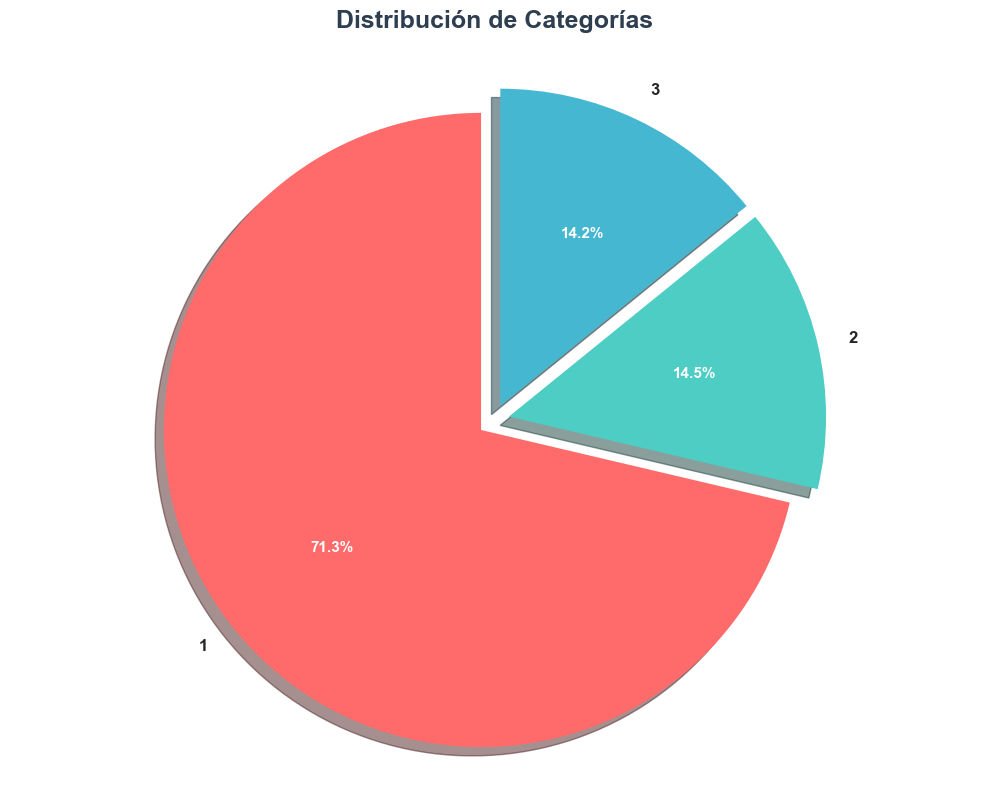

In [17]:
import matplotlib.pyplot as plt

# Configurar el estilo moderno
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(10, 8))

# Colores modernos con gradiente
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FECA57']

# Crear el gráfico de tarta moderno
wedges, texts, autotexts = plt.pie(
    category_counts.values,
    labels=category_counts.index,
    autopct='%1.1f%%',
    colors=colors[:len(category_counts)],
    startangle=90,
    explode=[0.05] * len(category_counts),  # Separar ligeramente las secciones
    shadow=True,
    textprops={'fontsize': 12, 'weight': 'bold'}
)

# Mejorar la apariencia del texto
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(11)
    autotext.set_weight('bold')

# Título moderno
plt.title('Distribución de Categorías',
          fontsize=18,
          weight='bold',
          pad=20,
          color='#2C3E50')

# Quitar los ejes para un look más limpio
plt.axis('equal')

# Mostrar el gráfico
plt.tight_layout()
plt.show()

# 3. Análisis de Temas (Capítulos)


In [18]:
print("=" * 60)
print("ANÁLISIS POR TEMAS (CAPÍTULOS)")
print("=" * 60)

# Distribución de temas
chapter_counts = df['chapter'].value_counts().sort_index()
print(f"\nTotal de temas únicos: {df['chapter'].nunique()}")
print(f"Rango de temas: {df['chapter'].min()} - {df['chapter'].max()}")

# Estadísticas descriptivas de temas
print(f"\nEstadísticas de distribución por temas:")
print(f"  Media de preguntas por tema: {chapter_counts.mean():.2f}")
print(f"  Mediana: {chapter_counts.median():.2f}")
print(f"  Desviación estándar: {chapter_counts.std():.2f}")
print(f"  Mínimo: {chapter_counts.min()} preguntas")
print(f"  Máximo: {chapter_counts.max()} preguntas")

# Temas con más y menos preguntas
print(f"\nTemas con más preguntas:")
top_chapters = chapter_counts.head(10)
for chapter, count in top_chapters.items():
    print(f"  Tema {chapter}: {count} preguntas")

print(f"\nTemas con menos preguntas:")
bottom_chapters = chapter_counts.tail(10)
for chapter, count in bottom_chapters.items():
    print(f"  Tema {chapter}: {count} preguntas")


ANÁLISIS POR TEMAS (CAPÍTULOS)

Total de temas únicos: 45
Rango de temas: 1 - 45

Estadísticas de distribución por temas:
  Media de preguntas por tema: 446.04
  Mediana: 286.00
  Desviación estándar: 422.95
  Mínimo: 195 preguntas
  Máximo: 2202 preguntas

Temas con más preguntas:
  Tema 1: 2202 preguntas
  Tema 2: 450 preguntas
  Tema 3: 195 preguntas
  Tema 4: 274 preguntas
  Tema 5: 559 preguntas
  Tema 6: 398 preguntas
  Tema 7: 234 preguntas
  Tema 8: 524 preguntas
  Tema 9: 474 preguntas
  Tema 10: 593 preguntas

Temas con menos preguntas:
  Tema 36: 286 preguntas
  Tema 37: 217 preguntas
  Tema 38: 255 preguntas
  Tema 39: 284 preguntas
  Tema 40: 257 preguntas
  Tema 41: 268 preguntas
  Tema 42: 551 preguntas
  Tema 43: 650 preguntas
  Tema 44: 326 preguntas
  Tema 45: 250 preguntas


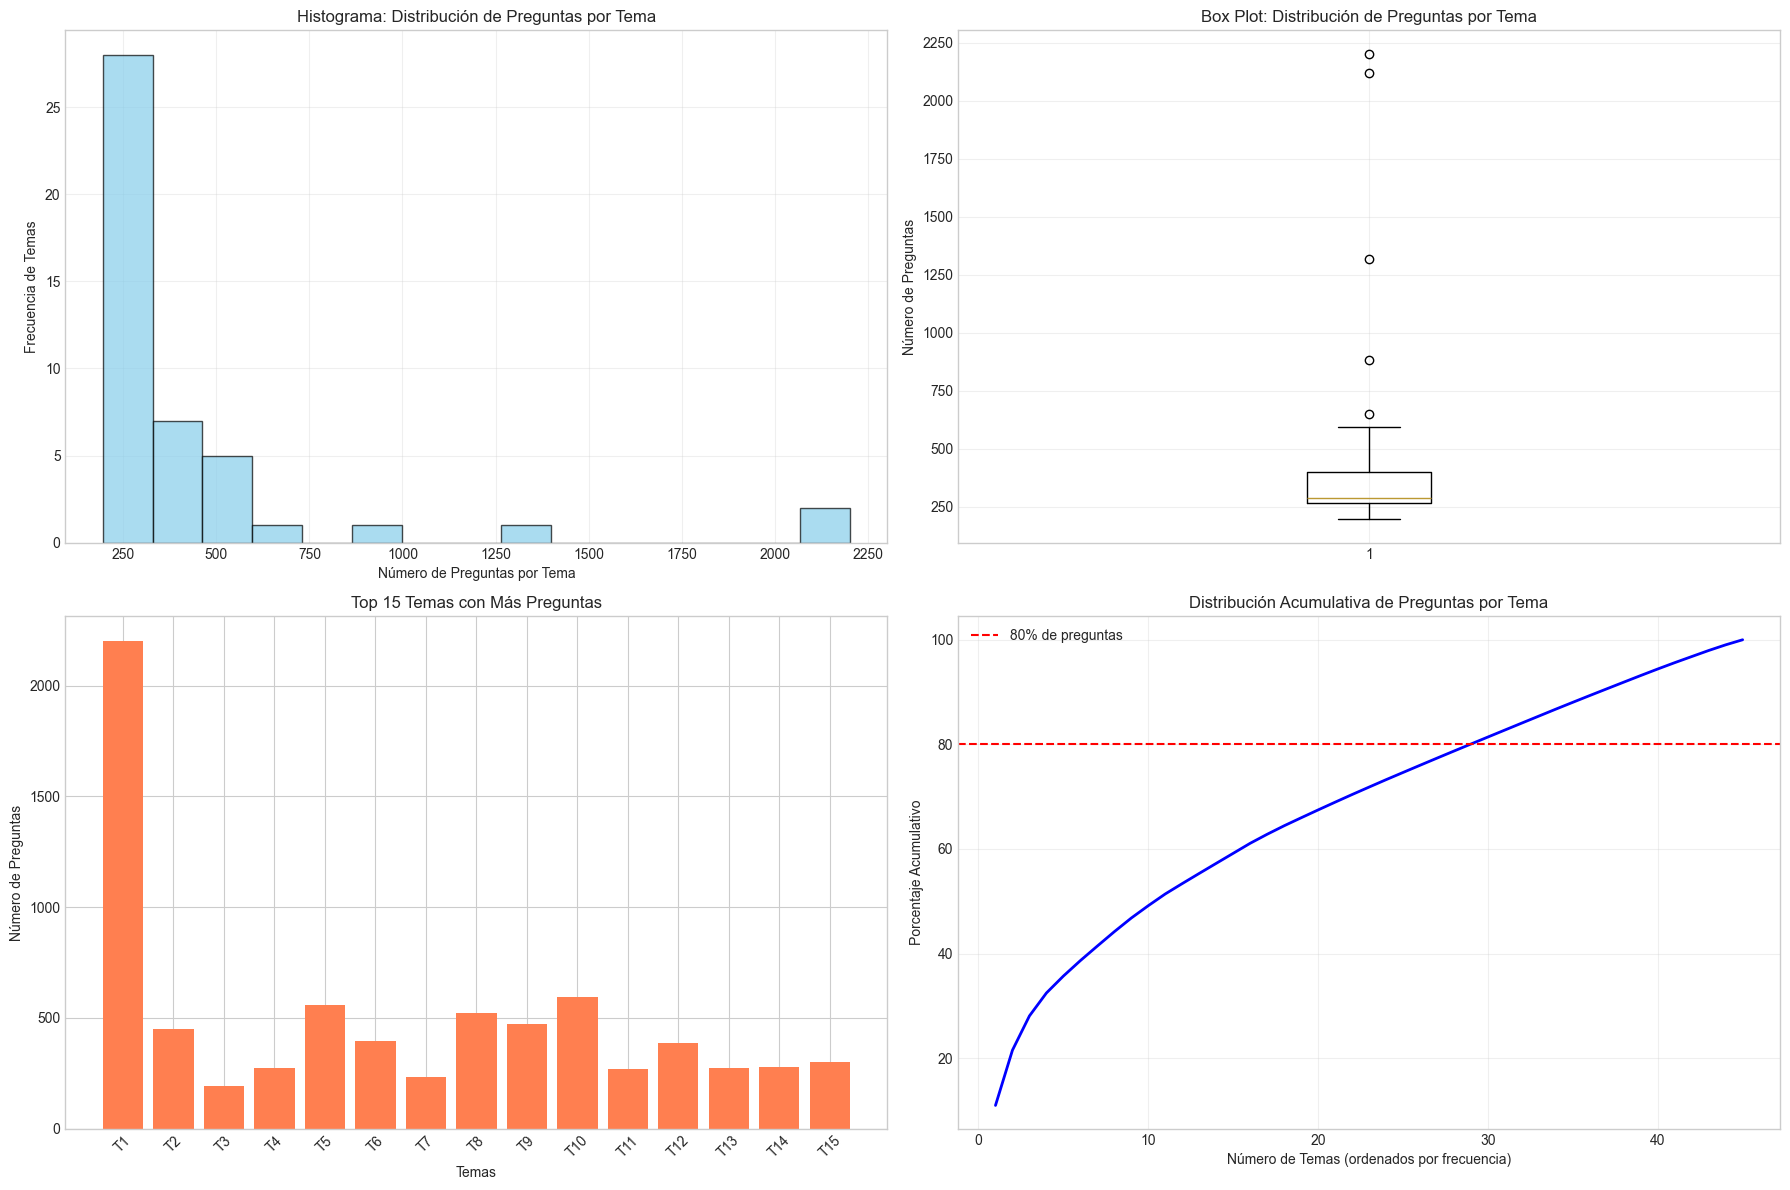

In [19]:
# Visualización de distribución de temas
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Histograma de distribución
axes[0, 0].hist(chapter_counts.values, bins=15, alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Histograma: Distribución de Preguntas por Tema')
axes[0, 0].set_xlabel('Número de Preguntas por Tema')
axes[0, 0].set_ylabel('Frecuencia de Temas')
axes[0, 0].grid(True, alpha=0.3)

# Box plot de distribución
axes[0, 1].boxplot(chapter_counts.values, vert=True)
axes[0, 1].set_title('Box Plot: Distribución de Preguntas por Tema')
axes[0, 1].set_ylabel('Número de Preguntas')
axes[0, 1].grid(True, alpha=0.3)

# Top 15 temas
top_15 = chapter_counts.head(15)
axes[1, 0].bar(range(len(top_15)), top_15.values, color='coral')
axes[1, 0].set_title('Top 15 Temas con Más Preguntas')
axes[1, 0].set_xlabel('Temas')
axes[1, 0].set_ylabel('Número de Preguntas')
axes[1, 0].set_xticks(range(len(top_15)))
axes[1, 0].set_xticklabels([f'T{i}' for i in top_15.index], rotation=45)

# Distribución acumulativa
sorted_counts = np.sort(chapter_counts.values)[::-1]
cumulative_percentage = np.cumsum(sorted_counts) / sum(sorted_counts) * 100
axes[1, 1].plot(range(1, len(cumulative_percentage) + 1), cumulative_percentage, 'b-', linewidth=2)
axes[1, 1].axhline(y=80, color='red', linestyle='--', label='80% de preguntas')
axes[1, 1].set_title('Distribución Acumulativa de Preguntas por Tema')
axes[1, 1].set_xlabel('Número de Temas (ordenados por frecuencia)')
axes[1, 1].set_ylabel('Porcentaje Acumulativo')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


# 4. Análisis Cruzado: Categorías vs Temas


In [20]:
print("=" * 60)
print("ANÁLISIS CRUZADO: CATEGORÍAS vs TEMAS")
print("=" * 60)

# Tabla cruzada
cross_table = pd.crosstab(df['category'], df['chapter'])
print("Tabla cruzada (primeras 10 columnas):")
print(cross_table.iloc[:, :10])

# Análisis por categoría
print("\nDistribución de temas por categoría:")
for category in df['category'].unique():
    category_data = df[df['category'] == category]
    n_themes = category_data['chapter'].nunique()
    themes_range = f"{category_data['chapter'].min()}-{category_data['chapter'].max()}"
    print(f"\n{category}:")
    print(f"  Total preguntas: {len(category_data)}")
    print(f"  Temas únicos: {n_themes}")
    print(f"  Rango de temas: {themes_range}")

    # Top 5 temas por categoría
    top_themes = category_data['chapter'].value_counts().head(5)
    print(f"  Top 5 temas:")
    for theme, count in top_themes.items():
        print(f"    Tema {theme}: {count} preguntas")


ANÁLISIS CRUZADO: CATEGORÍAS vs TEMAS
Tabla cruzada (primeras 10 columnas):
chapter     1    2    3    4    5    6    7    8    9    10
category                                                   
1         2202  450  195  274  559  398  234  524  474  593
2            0    0    0    0    0    0    0    0    0    0
3            0    0    0    0    0    0    0    0    0    0

Distribución de temas por categoría:

1:
  Total preguntas: 14316
  Temas únicos: 26
  Rango de temas: 1-26
  Top 5 temas:
    Tema 1: 2202 preguntas
    Tema 16: 2120 preguntas
    Tema 21: 1315 preguntas
    Tema 23: 880 preguntas
    Tema 10: 593 preguntas

2:
  Total preguntas: 2915
  Temas únicos: 11
  Rango de temas: 27-37
  Top 5 temas:
    Tema 30: 297 preguntas
    Tema 32: 293 preguntas
    Tema 36: 286 preguntas
    Tema 29: 269 preguntas
    Tema 31: 268 preguntas

3:
  Total preguntas: 2841
  Temas únicos: 8
  Rango de temas: 38-45
  Top 5 temas:
    Tema 43: 650 preguntas
    Tema 42: 551 preguntas
   

[1 2 3]
[1 2 3]
[1 2 3]


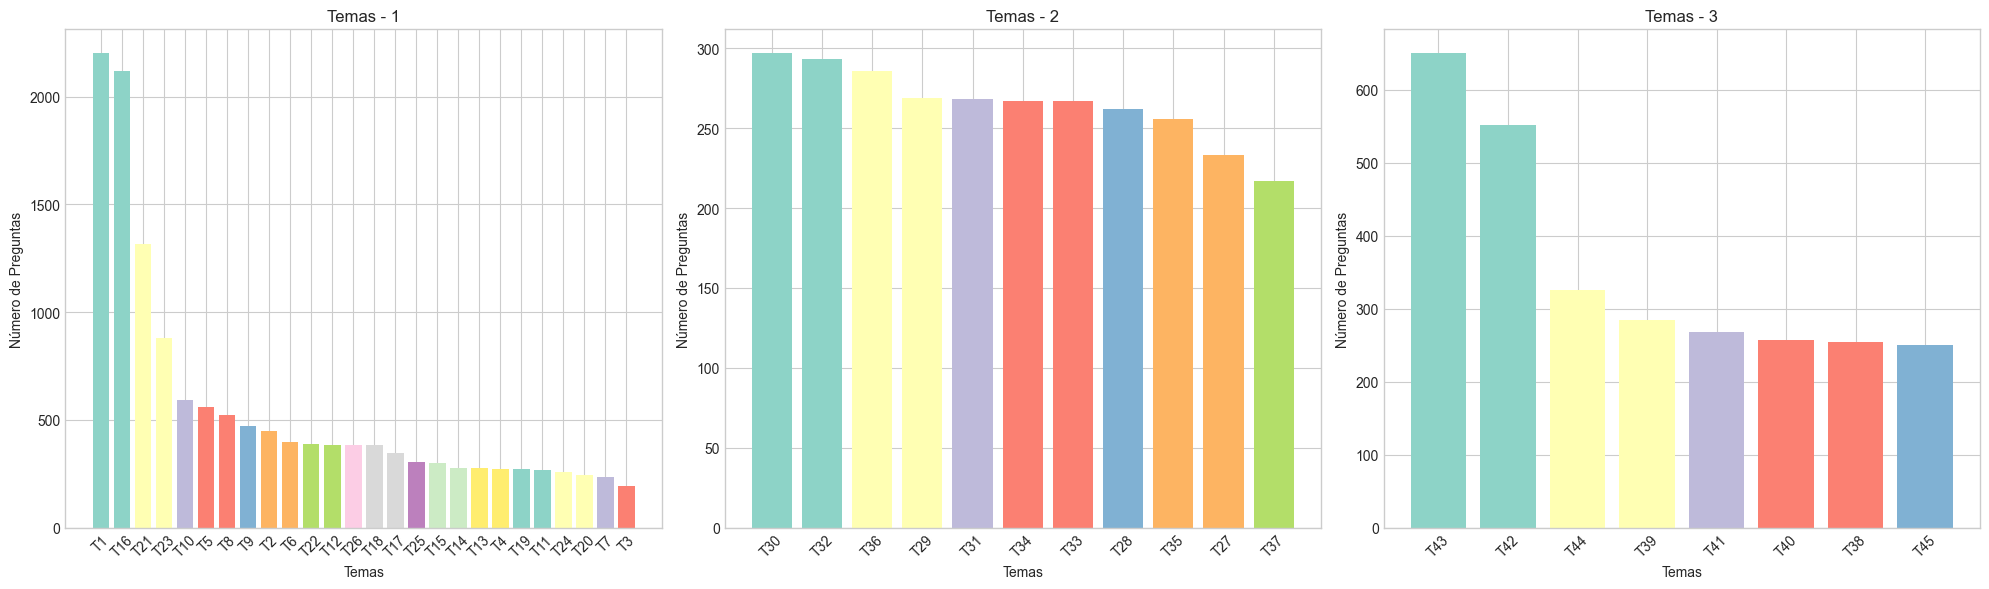

In [22]:
# Gráfico de barras apiladas por categoría
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

categories = df['category'].dropna().unique()
colors_themes = plt.cm.Set3(np.linspace(0, 1, 20))  # 20 colores diferentes

for i, category in enumerate(categories):
    category_data = df[df['category'] == category]
    theme_counts = category_data['chapter'].value_counts().head(27)
    print(categories)
    axes[i].bar(range(len(theme_counts)), theme_counts.values,
                color=colors_themes[:len(theme_counts)])
    axes[i].set_title(f'Temas - {category}')
    axes[i].set_xlabel('Temas')
    axes[i].set_ylabel('Número de Preguntas')
    axes[i].set_xticks(range(len(theme_counts)))
    axes[i].set_xticklabels([f'T{t}' for t in theme_counts.index], rotation=45)

plt.tight_layout()
plt.show()


# 5. Procesamiento de Embeddings para Visualización


In [23]:
print("=" * 60)
print("PROCESAMIENTO DE EMBEDDINGS")
print("=" * 60)

# Procesar vectores embeddings
print("Procesando vectores embeddings...")
vectors = [convert_string_to_array(vec) for vec in df['vector']]

# Estadísticas de vectores
vector_lengths = [len(vec) for vec in vectors]
print(f"Longitud mínima: {min(vector_lengths)}")
print(f"Longitud máxima: {max(vector_lengths)}")
print(f"Longitud promedio: {np.mean(vector_lengths):.2f}")

# Padear vectores
max_length = max(vector_lengths)
padded_vectors = [pad_vector(vec, max_length) for vec in vectors]
X = np.array(padded_vectors)

print(f"Forma final de la matriz X: {X.shape}")

# Aplicar PCA para reducción de dimensionalidad
from sklearn.decomposition import PCA

print("\nAplicando PCA...")
pca = PCA(n_components=50, random_state=42)  # 50 componentes para visualización
X_pca = pca.fit_transform(X)

variance_explained = pca.explained_variance_ratio_.sum()
print(f"Varianza explicada con 50 componentes: {variance_explained:.4f}")


PROCESAMIENTO DE EMBEDDINGS
Procesando vectores embeddings...
Longitud mínima: 1536
Longitud máxima: 3072
Longitud promedio: 3071.23
Forma final de la matriz X: (20072, 3072)

Aplicando PCA...
Varianza explicada con 50 componentes: 0.4752


# 6. Visualización con t-SNE


Creando visualización t-SNE...
Categorías únicas encontradas: [1 2 3]


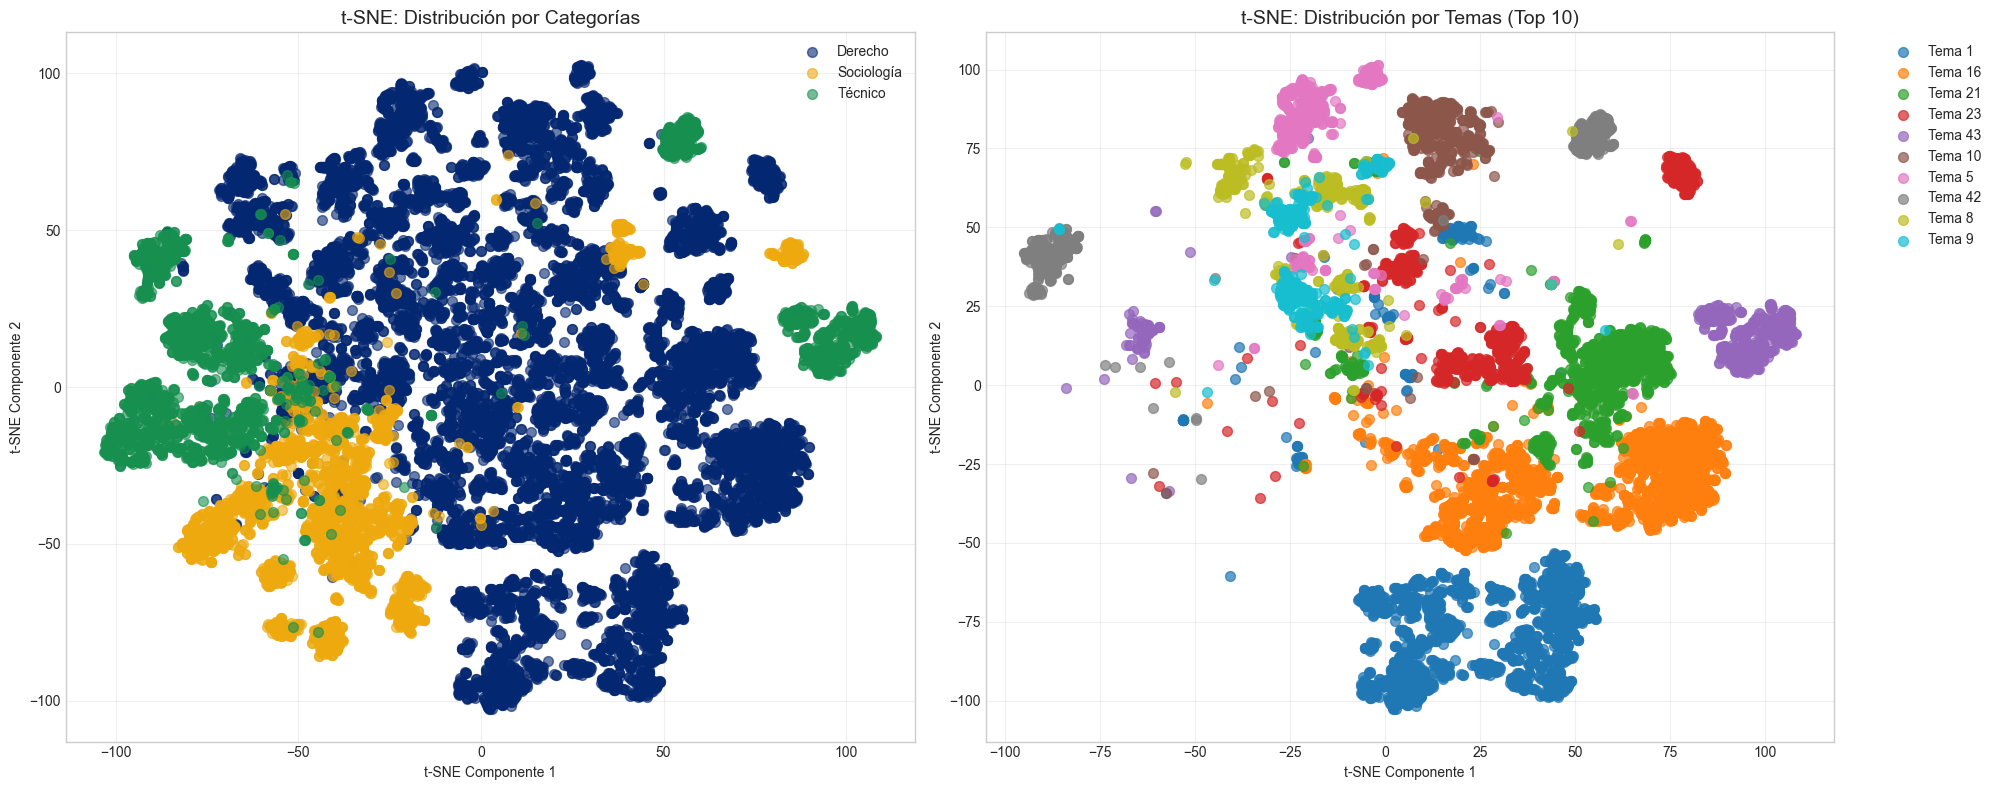

In [24]:
from sklearn.manifold import TSNE

print("Creando visualización t-SNE...")

# t-SNE para 2D
tsne_2d = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
X_tsne_2d = tsne_2d.fit_transform(X_pca)

# Crear visualizaciones separadas
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Verificar y mapear categorías
print("Categorías únicas encontradas:", df['category'].unique())

# Crear mapeo de números a nombres de categorías
# Basado en los datos, asumimos: 1=Derecho, 2=Sociología, 3=Técnico
category_mapping = {1.0: 'Derecho', 2.0: 'Sociología', 3.0: 'Técnico'}
category_colors = {'Derecho': '#042771', 'Sociología': '#EDA90E', 'Técnico': '#168F4F'}

# Visualización por categorías
for cat_num, cat_name in category_mapping.items():
    mask = df['category'] == cat_num
    if np.sum(mask) > 0:  # Solo si hay datos para esta categoría
        axes[0].scatter(X_tsne_2d[mask, 0], X_tsne_2d[mask, 1],
                       c=category_colors[cat_name], label=cat_name, alpha=0.6, s=50)

axes[0].set_title('t-SNE: Distribución por Categorías', fontsize=14)
axes[0].set_xlabel('t-SNE Componente 1')
axes[0].set_ylabel('t-SNE Componente 2')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Visualización por temas (solo top 10 para claridad)
# Filtrar datos válidos (sin NaN en category)
df_valid = df.dropna(subset=['category'])
if len(df_valid) > 0:
    valid_chapter_counts = df_valid['chapter'].value_counts()
    top_10_themes = valid_chapter_counts.head(10).index
    theme_colors = plt.cm.tab10(np.linspace(0, 1, 10))

    # Crear máscara para datos válidos
    valid_mask = ~df['category'].isna()
    X_tsne_valid = X_tsne_2d[valid_mask]
    df_valid_indexed = df_valid.reset_index(drop=True)

    for i, theme in enumerate(top_10_themes):
        theme_mask = df_valid_indexed['chapter'] == theme
        if np.sum(theme_mask) > 0:  # Solo si hay datos para este tema
            axes[1].scatter(X_tsne_valid[theme_mask, 0], X_tsne_valid[theme_mask, 1],
                           c=[theme_colors[i]], label=f'Tema {theme}', alpha=0.7, s=50)
else:
    axes[1].text(0.5, 0.5, 'No hay datos válidos para mostrar',
                transform=axes[1].transAxes, ha='center', va='center')

axes[1].set_title('t-SNE: Distribución por Temas (Top 10)', fontsize=14)
axes[1].set_xlabel('t-SNE Componente 1')
axes[1].set_ylabel('t-SNE Componente 2')
axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()